<a href="https://colab.research.google.com/github/Pongpang-2102/Text_Mining_and_Sentiment_Analytics_KDAI_projects/blob/main/KDAI_TMSA_Midterm_Project_(12_Sep_23)_%E0%B8%82%E0%B9%89%E0%B8%AD_2_2_Sentiment_Analysis_Puriwat_65056071.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#  Midterm Project วิชา Text Mining and Sentiment Analytics (1/2566)

## Student info

- Name : Puriwat Sangrawee ( นายภูริวัฒน์ แสงระวี)
- Student ID : 65056071
- สาขาวิชา : วิทยาการข้อมูลและการวิเคราะห์ (ชั้นปีที่ 2 )

# 2.2 Sentiment Analysis

### 00 : Data Prep

**คำชี้แจง**
- เปรียบเทียบระหว่างโมเดล LSTM และ CNN พร้อมอธิบายปัญหาที่พบและการทำ Pre-Process การปรับค่าต่าง ๆ เพื่อให้ได้ประสิทธิภาพที่ดีขึ้น

- Import package ที่จำเป็น & Mount drive

In [ ]:
!pip install pythainlp

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.4/13.4 MB 40.9 MB/s eta 0:00:00


In [ ]:
pip install tensorflow --upgrade

In [ ]:
pip install keras --upgrade

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 14.6 MB/s eta 0:00:00
  Attempting uninstall: keras
    Found existing installation: keras 2.13.1
    Uninstalling keras-2.13.1:
      Successfully uninstalled keras-2.13.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.13.0 requires keras<2.14,>=2.13.1, but you have keras 2.14.0 which is incompatible.


In [ ]:
import tensorflow as tf
Model = tf.keras.models.Model
ModelCheckpoint = tf.keras.callbacks.ModelCheckpoint
ReduceLROnPlateau = tf.keras.callbacks.ReduceLROnPlateau
load_model = tf.keras.models.load_model

import pandas as pd
import re
from nltk.tokenize import word_tokenize
from pythainlp.tokenize import word_tokenize, Tokenizer
from tensorflow.keras.preprocessing.text import Tokenizer
KRTokenizer = tf.keras.preprocessing.text.Tokenizer

pad_sequences = tf.keras.preprocessing.sequence.pad_sequences
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split

import numpy as np

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, GRU, LSTM, Bidirectional, Embedding, Dropout, BatchNormalization
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import ModelCheckpoint

from tensorflow.keras.optimizers import Adam

import seaborn as sn
import matplotlib.pyplot as plt

import pickle as p
import plotly
import plotly.graph_objs as go

from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

import string
# from os import listdir
from string import punctuation
# from os import listdir

#########################
from pythainlp.tokenize import word_tokenize #, Tokenizer
from pythainlp.corpus.common import thai_words

import nltk
nltk.download('stopwords')

from nltk.corpus import stopwords
stop_words = stopwords.words('english')

from pythainlp.corpus import thai_stopwords

from gensim.models import Word2Vec

import seaborn as sn
import matplotlib.pyplot as plt

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


- กำหนดจำนวน EPOCHS และ Batch Size ดังต่อไปนี้

- Load Dataset ซึ่งประกอบด้วย ข้อความ (comments), ผลเฉลย (labels)

#### 00-1 Rerun Model Here

In [ ]:
comments = []
labels = []

# upload file : femcomment.txt as training data

# with open("train.txt",encoding="utf-8") as f:
with open("/content/drive/MyDrive/# KDAI_TextMining/Exam 4-10 Sep 23/Problem02/femcomment.txt",encoding="utf-8") as f:
    for line in f:
        comments.append(line.strip())

# upload file : femcomment_label.txt as label
# with open("train_label.txt",encoding="utf-8") as f:
with open("/content/drive/MyDrive/# KDAI_TextMining/Exam 4-10 Sep 23/Problem02/femcomment_label.txt",encoding="utf-8") as f:
    for line in f:
        labels.append(line.strip())

In [ ]:
df = pd.DataFrame({ "category": labels, "comments": comments })

In [ ]:
# to view column name
df.columns

Index(['category', 'comments'], dtype='object')

In [ ]:
print(f"number of record : {df.shape[0]}")
print(f"number of  column : {df.shape[1]}")

number of record : 500
number of  column : 2


- เรียกดูข้อมูล dataframe ที่เราเพิ่งสร้าง

In [ ]:
df.head()

,category,comments
0,neg,เฟมทวิตคือคนที่ลากทุกอย่างไปเป็นเรื่อง ความไม่...
1,neg,จะเฟมินิสต์หรือเฟมทวิต ก็ไม่เคยเป็นคำที่ได้รับ...
2,neg,และถ้าเทียบการพยายามดิสเครดิต ก็เทียบได้กับคำว...
3,neg,เฟมทวิตดูโง่เพราะคนอย่างนี้แหละค่ะ
4,neg,เฟมทวิตไม่น่าจะอยากคุยกับคนแบบมึงนะ


- ลบข้อมูลซ้ำ (ถ้ามี)

In [ ]:
df = df.drop_duplicates()

- ดูจำนวน record หลังลบข้อมูลซ้ำ

In [ ]:
print(f"number of record : {df.shape[0]}")
print(f"number of  column : {df.shape[1]}")

number of record : 500
number of  column : 2


- ดูว่าข้อมูลต้นฉบับที่โจทย์ให้มา มี Positive (pos) หรือ Negative (neg) อย่างละเท่าไหร่บ้าง

In [ ]:
positive_comment = (df['category'] == "pos").sum()
negative_comment = (df['category'] == "neg").sum()

print(f"Positive comment : {positive_comment}")
print(f"Negative comment : {negative_comment}")

Positive comment : 250
Negative comment : 250


- ลองดูตัวอย่างข้อมูลแต่ละกลุ่ม

In [ ]:
df[df['category'] == "neg"].head()

,category,comments
0,neg,เฟมทวิตคือคนที่ลากทุกอย่างไปเป็นเรื่อง ความไม่...
1,neg,จะเฟมินิสต์หรือเฟมทวิต ก็ไม่เคยเป็นคำที่ได้รับ...
2,neg,และถ้าเทียบการพยายามดิสเครดิต ก็เทียบได้กับคำว...
3,neg,เฟมทวิตดูโง่เพราะคนอย่างนี้แหละค่ะ
4,neg,เฟมทวิตไม่น่าจะอยากคุยกับคนแบบมึงนะ


In [ ]:
df[df['category'] == "neg"].tail()

,category,comments
245,neg,บอกว่ากุด่าผช(ที่ไปคอมเม้นเหี้ยๆในโพสยิปซี)ว่า...
246,neg,คือพอเค้าดิสคัสกันเรื่องความเท่าเทียมทางเพศนี่...
247,neg,ถ้าเท่าเทียมแล้วผมต่อยผู้หญิงได้มั้ย/ถ้าเท่าเท...
248,neg,ต่อให้เกาหลีพัฒนาไปมากแค่ไหน แต่ก็คือบ้งเรื่อง...
249,neg,เฟมทวิตไม่ควรมีชีวิตอยู่บนโลก


In [ ]:
df[df['category'] == "pos"].head()

,category,comments
250,pos,ให้มีความเสมอภาคกันมากที่สุดแบบนี้ตังหาก
251,pos,สมาคมฟ้าสีรุ้งฯ ยื่นโฆษก กมธ. ยกร่างข้อบังคับฯ...
252,pos,เพื่อศึกษาสร้างความเข้าใจ และร่วมผลักดันในระดั...
253,pos,คือการประชุมสุดยอดที่ว่าด้วยเรื่องความเท่าเทีย...
254,pos,ความเท่าเทียมกันของมนุษย์ และความหลากหลายทางเพศ


In [ ]:
df[df['category'] == "pos"].tail()

,category,comments
495,pos,หากให้สิทธิที่เท่าเทียมกับพวกเขา พวกเขาก็จะมีค...
496,pos,แต่ทุกคนต้องมีความเท่าเทียมกันในฐานะมนุษย์ มีส...
497,pos,และการศึกษาก็ควรจะเป็นสิ่งที่ทำให้เข้าถึงง่ายใ...
498,pos,แต่สิ่งที่ควรทำคือ ควรจะผลักดันให้เกิดความเท่า...
499,pos,เพื่อให้ทุกโอกาสเข้าไปถึงคนทุกชนชั้น คนทุกเพศ ...


- กำหนดอักขระที่ไม่ต้องการ

In [ ]:
pun = '"#\'()*,-.;<=>[\\]^_`{|}~'
pun

'"#\'()*,-.;<=>[\\]^_`{|}~'

- ลบอักขระที่ไม่ต้องการ

In [ ]:
df['comments']= df['comments'].str.replace(r'[%s]' % (pun), '', regex=True)

In [ ]:
df.sample(3)

,category,comments
279,pos,พัฒนาความเท่าเทียมทางเพศในทุกมิติให้ดีขึ้นได้
38,neg,ทำให้เมื่อผู้ชายโดนข่มขืนและล่วงละเมิดทางเพศ พ...
107,neg,เสือกไร มึงเมนชั่นมาหากู กูก็จะด่า มึงรุ้ปะ เพ...


In [ ]:
category = df.category.values
category.shape

(500,)

- สร้างฟังก์ชันเพื่อทำความสะอาดข้อมูล  ซึ่งเราจะรับเข้าทุกภาษา หากเป็นภาษาอังกฤษเราจะแปลงเป็นอักษรตัวเล็ก (lowercase) จากนั้นเก็บแต่ละคำของแต่ละประโยคไว้ใน List (temp) เพื่อหาความยาวของประโยค รวมทั้งเก็บแต่ละประโยคแบบ String (words) เพื่อสร้าง Train Data

In [ ]:
def cleaning(sentences):
  words = []
  temp = []
  for s in sentences:
    # clean = re.sub(r'[^ก-๙]', "", s)
    #w = word_tokenize(clean)
    w = word_tokenize(s)

    # ปรับตัวอักษรภาษาอังกฤษ ให้เป็น lowercase
    temp.append([i.lower() for i in w])
    words.append(' '.join(w).lower())

  return words, temp

- Clean ประโยคทั้งหมด

In [ ]:
cleaned_words, temp = cleaning(comments)
print(len(cleaned_words))
print(cleaned_words[495:])

500
['หาก ให้ สิทธิ ที่ เท่าเทียม กับ พวกเขา   พวกเขา ก็ จะ มีความสุข มากขึ้น', 'แต่ ทุกคน ต้อง มี ความเท่าเทียมกัน ใน ฐานะ มนุษย์   มี สิทธิ ที่จะ แสดงออก อย่าง เท่าเทียมกัน จ้ะ', 'และ การศึกษา ก็ ควรจะเป็น สิ่ง ที่ ทำให้ เข้าถึง ง่าย ให้ เกิด ความเท่าเทียม มาก ที่สุด เพื่อ ไม่ ให้ เกิด ความเหลื่อมล้ำ ทางสังคม', 'แต่ สิ่ง ที่ ควร ทำ คือ   ควรจะ ผลักดัน ให้ เกิด ความเท่าเทียมกัน มาก ที่สุด', 'เพื่อให้ ทุก โอกาส เข้าไป ถึง คน ทุก ชนชั้น   คน ทุก เพศ   คน ทุก วัย']


- นิยาม Function `create_tokenizer` เพื่อสร้าง `Keras TokenizerObject`

In [ ]:
def create_tokenizer(words, filters = ''):
    token = Tokenizer(filters=filters)
    token.fit_on_texts(words)
    return token

- สร้าง Keras Tokenizer Object ที่มีการ Train ด้วย Sentence ที่ถูก Cleaning แล้ว ซึ่งเราจะได้ `Bag of Word` และ `จำนวนคำศัพท์` ของ Bag of Word จาก Keras Tokenizer ดังภาพด้านล่าง

In [ ]:
train_word_tokenizer = create_tokenizer(cleaned_words)
vocab_size = len(train_word_tokenizer.word_index) +1

In [ ]:
vocab_size

1694

In [ ]:
train_word_tokenizer.word_index

{'ทางเพศ': 1,
 'ที่': 2,
 'ไม่': 3,
 'ทวิ': 4,
 'ต': 5,
 'เฟม': 6,
 'ความเท่าเทียม': 7,
 'ก็': 8,
 'เป็น': 9,
 'และ': 10,
 'มี': 11,
 'จะ': 12,
 'ใน': 13,
 'ได้': 14,
 'ว่า': 15,
 'ของ': 16,
 'ให้': 17,
 'เพศ': 18,
 'เรื่อง': 19,
 'คน': 20,
 'ไป': 21,
 'พวก': 22,
 'แต่': 23,
 'มึง': 24,
 'ขยะสังคม': 25,
 'กัน': 26,
 'การ': 27,
 'เรา': 28,
 'ผู้ชาย': 29,
 'มา': 30,
 'มัน': 31,
 'ผู้หญิง': 32,
 'ๆ': 33,
 'ความเท่าเทียมกัน': 34,
 'นะ': 35,
 'คือ': 36,
 'เลย': 37,
 'กับ': 38,
 'แล้ว': 39,
 'เรียกร้อง': 40,
 'เฟมินิสต์': 41,
 'ทุกคน': 42,
 'เพื่อ': 43,
 'อะไร': 44,
 'ทุก': 45,
 'สนับสนุน': 46,
 'กู': 47,
 'เท่าเทียมกัน': 48,
 'อี': 49,
 'ความหลากหลาย': 50,
 'เพราะ': 51,
 'ต้อง': 52,
 'มาก': 53,
 'อยาก': 54,
 'ถ้า': 55,
 'เหี้ย': 56,
 'อยู่': 57,
 'ด่า': 58,
 'สังคม': 59,
 'ควร': 60,
 'สิทธิ': 61,
 'อย่าง': 62,
 'ชาย': 63,
 'แค่': 64,
 'เท่าเทียม': 65,
 'ค่ะ': 66,
 'ด้วย': 67,
 '\u200b': 68,
 'กว่า': 69,
 'ตัวเอง': 70,
 'หรือ': 71,
 'อะ': 72,
 'เกาหลี': 73,
 'แบบ': 74,
 'ไหน': 75,
 'นี้': 76

- นิยาม Function เพื่อหาความยาวสูงสุดของคำในประโยค ซึ่งเราจะค้นหาประโยคที่มีความยาวสูงสูดโดยใช้  Parameter key = len และนับคำในประโยคโดยใช้ Function len

In [ ]:
def max_length(words):
    return(len(max(words, key = len)))

- กำหนด`ความยาวสูงสุด`ของ`คำในประโยค`ให้กับ max_length เพื่อเตรียมทำ `Padding` และกำหนด`จำนวน Step` ของ `LSTM Network` ซึ่งพบว่า *ประโยคยาวที่สุดมีความยาว 51 คำ*

In [ ]:
max_length = max_length(temp)
max_length

51

- นิยาม Function เพื่อแปลงคำเป็นตัวเลข

In [ ]:
def encoding_doc(token, words):
    return(token.texts_to_sequences(words))

- แปลงคำในประโยคที่ได้ทำ Cleaning เป็นตัวเลข ด้วย Keras Tokenizer Object ที่ถูก Train แล้ว

In [ ]:
encoded_doc = encoding_doc(train_word_tokenizer, cleaned_words)

print(cleaned_words[0])
print(encoded_doc[0])

เฟม ทวิ ต คือ คน ที่ ลาก ทุกอย่าง ไป เป็นเรื่อง   ความ ไม่ เท่าเทียมกัน ของ ชญ. ได้ หมด   เพื่อ ด่า ผช.   มี ลักษณะ คล้าย   feminism   ยุค บุกเบิก
[6, 4, 5, 36, 20, 2, 783, 356, 21, 142, 82, 3, 48, 16, 784, 14, 277, 43, 58, 149, 11, 785, 786, 787, 222, 788]


- นิยาม Function เพื่อทำ Padding ตัวเลขที่แทนแต่ละคำในประโยค โดยกำหนดให้มีการเติม 0 เพื่อให้แต่ละประโยคมีความยาวเท่ากัน (51 คำ)

In [ ]:
def padding_doc(encoded_doc, max_length):
    return(pad_sequences(encoded_doc, maxlen = max_length, padding = "post"))

- ทำ Padding

In [ ]:
padded_doc = padding_doc(encoded_doc, max_length)
print("Shape of padded docs = ",padded_doc.shape)

print(cleaned_words[0])
print(encoded_doc[0])
print(padded_doc[0])

Shape of padded docs =  (500, 51)
เฟม ทวิ ต คือ คน ที่ ลาก ทุกอย่าง ไป เป็นเรื่อง   ความ ไม่ เท่าเทียมกัน ของ ชญ. ได้ หมด   เพื่อ ด่า ผช.   มี ลักษณะ คล้าย   feminism   ยุค บุกเบิก
[6, 4, 5, 36, 20, 2, 783, 356, 21, 142, 82, 3, 48, 16, 784, 14, 277, 43, 58, 149, 11, 785, 786, 787, 222, 788]
[  6   4   5  36  20   2 783 356  21 142  82   3  48  16 784  14 277  43
  58 149  11 785 786 787 222 788   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]


In [ ]:
unique_category = list(set(category))
unique_category

['pos', 'neg']

- สร้าง output_tokenizer ด้วยการ Train tokenizer ด้วยชื่อ Class ทั้งหมด 2 Class

In [ ]:
output_tokenizer = create_tokenizer(unique_category)

- แปลงผลเฉลยเป็นตัวเลขโดยใช้ output_tokenizer

In [ ]:
encoded_output = encoding_doc(output_tokenizer, category)
print(category[0:5])
print(encoded_output[0:5])

['neg' 'neg' 'neg' 'neg' 'neg']
[[2], [2], [2], [2], [2]]


- เพิ่มมิติของผลเฉลยจาก `500` เป็น `500 x 1` สำหรับการเข้ารหัสผลเฉลยแบบ `One Hot`

In [ ]:
encoded_output = np.array(encoded_output).reshape(len(encoded_output), 1)
encoded_output.shape

(500, 1)

- นิยาม Function การเข้ารหัสผลเฉลยแบบ One Hot

In [ ]:
def one_hot(encode):
  oh = OneHotEncoder(sparse = False)
  return(oh.fit_transform(encode))

- เข้ารหัสผลเฉลยแบบ One Hot

In [ ]:
output_one_hot = one_hot(encoded_output)
print(encoded_output[0])
print(output_one_hot[0])

[2]
[0. 1.]


/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning:

`sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.



- แบ่ง Input Data พร้อมผลเฉลย (Dataset) สำหรับ Train 80% และ Validate 20% โดยใช้ Parameter แบบ `Stratified Sampling` เพื่อให้มั่นใจว่าจะได้ Validate Dataset ที่มีข้อมูลครบทุก Intent

In [ ]:
train_X, val_X, train_Y, val_Y = train_test_split(padded_doc, output_one_hot, shuffle = True, test_size = 0.2, stratify=output_one_hot)

- Print Shape ของ Dataset

In [ ]:
print("Shape of train_X = %s and train_Y = %s" % (train_X.shape, train_Y.shape))
print("Shape of val_X = %s and val_Y = %s" % (val_X.shape, val_Y.shape))

Shape of train_X = (400, 51) and train_Y = (400, 2)
Shape of val_X = (100, 51) and val_Y = (100, 2)


- กำหนดจำนวน Intent ให้กับ num_classes สำหรับนิยามจำนวน Output Node ของ `LSTM`

In [ ]:
num_classes = len(unique_category)
num_classes

2

## 01 : RNN - LSTM

- นิยาม Model แบบ `LSTM` ซึ่งเป็น Recurrent Neural Network (RNN) แบบหนึ่ง โดยกำหนดค่า learning rate (lr) ให้เป็น 0.0001  

In [ ]:
# from tensorflow.keras.optimizers import Adam
adam = Adam(learning_rate = 0.0001)

In [ ]:
# pip install tensorflow

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Bidirectional, LSTM, Dense, Dropout, BatchNormalization

In [ ]:
def create_model(vocab_size, max_length, num_classes):
    model = Sequential()

    model.add(Embedding(vocab_size, 128, input_length=max_length, trainable=True))

    # model required : LSTM
    model.add(Bidirectional(LSTM(128), merge_mode="concat"))

    # ซึ่งนอกจากต่อแบบ concat แล้ว ยังมีการต่อแบบอื่น ๆ คือ sum, mul และ ave

    # Hidden layer
    model.add(Dense(128, activation="relu"))
    model.add(Dropout(0.5))
    model.add(Dense(64, activation="relu"))
    model.add(Dropout(0.5))
    model.add(Dense(64, activation="relu"))
    model.add(Dropout(0.5))
    #model.add(Dense(64, activation="relu"))
    #model.add(Dropout(0.5))
    model.add(BatchNormalization())

    # output layer
    model.add(Dense(num_classes, activation="softmax"))

    return model

#vocab_size = 1694
#max_length = 51
#num_classes = 2

model = create_model(vocab_size, max_length , num_classes)

- Compile และ Print `ชนิดของ Layer`, `Output Shape` และ`จำนวน Parameter` ของ Model

In [ ]:
model.compile(loss = "categorical_crossentropy", optimizer = adam, metrics = ["accuracy"])
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_17 (Embedding)    (None, 51, 128)           216832    
                                                                 
 bidirectional_2 (Bidirecti  (None, 256)               263168    
 onal)                                                           
                                                                 
 dense_18 (Dense)            (None, 128)               32896     
                                                                 
 dropout_21 (Dropout)        (None, 128)               0         
                                                                 
 dense_19 (Dense)            (None, 64)                8256      
                                                                 
 dropout_22 (Dropout)        (None, 64)                0         
                                                      

- สร้างจุด Check Point เพื่อ `Save Model` เฉพาะ `Epoch` ที่มี `val_loss น้อยที่สุด`

In [ ]:
filename = 'model_tmsa_sentiment_lstm.h5'
checkpoint = ModelCheckpoint(filename, monitor='val_loss', verbose=1, save_best_only=True, mode='min')

- Train Model

In [ ]:
# specify epoch and batch size number
EPOCHS = 70
BS = 32

# โมเดลจำพวก transfer learning จะมีกระบวนการข้างในค่อนข้างเยอะ
# ทำให้การใช้จำนวนรอบ batch size น้อย การทำงานก็จะไวขึ้น

In [ ]:
hist = model.fit(train_X, train_Y, epochs = EPOCHS, batch_size = BS, validation_data = (val_X, val_Y), callbacks = [checkpoint])

Epoch 1/70
13/13 [==============================] - ETA: 0s - loss: 0.7156 - accuracy: 0.5450
Epoch 1: val_loss improved from inf to 0.69295, saving model to model_tmsa_sentiment_lstm.h5
13/13 [==============================] - 7s 218ms/step - loss: 0.7156 - accuracy: 0.5450 - val_loss: 0.6930 - val_accuracy: 0.6100
Epoch 2/70
 1/13 [=>............................] - ETA: 1s - loss: 0.6991 - accuracy: 0.5312

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning:

You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.



13/13 [==============================] - ETA: 0s - loss: 0.7281 - accuracy: 0.5450
Epoch 2: val_loss improved from 0.69295 to 0.69279, saving model to model_tmsa_sentiment_lstm.h5
13/13 [==============================] - 1s 109ms/step - loss: 0.7281 - accuracy: 0.5450 - val_loss: 0.6928 - val_accuracy: 0.6100
Epoch 3/70
13/13 [==============================] - ETA: 0s - loss: 0.6980 - accuracy: 0.5325
Epoch 3: val_loss improved from 0.69279 to 0.69269, saving model to model_tmsa_sentiment_lstm.h5
13/13 [==============================] - 2s 115ms/step - loss: 0.6980 - accuracy: 0.5325 - val_loss: 0.6927 - val_accuracy: 0.6800
Epoch 4/70
13/13 [==============================] - ETA: 0s - loss: 0.6723 - accuracy: 0.6025
Epoch 4: val_loss improved from 0.69269 to 0.69240, saving model to model_tmsa_sentiment_lstm.h5
13/13 [==============================] - 1s 106ms/step - loss: 0.6723 - accuracy: 0.6025 - val_loss: 0.6924 - val_accuracy: 0.6000
Epoch 5/70
13/13 [===========================

- Save History

In [ ]:
with open('history_model_tmsa_sentiment_lstm', 'wb') as file:
    p.dump(hist.history, file)

- Load History

In [ ]:
with open('history_model_tmsa_sentiment_lstm', 'rb') as file:
    his = p.load(file)

- Plot `Loss` และ `Validate Loss`

In [ ]:
h1 = go.Scatter(y=his['loss'],
                    mode="lines", line=dict(
                    width=2,
                    color='blue'),
                    name="loss"
                   )
h2 = go.Scatter(y=his['val_loss'],
                    mode="lines", line=dict(
                    width=2,
                    color='red'),
                    name="val_loss"
                   )

data = [h1,h2]
layout1 = go.Layout(title='Loss',
                   xaxis=dict(title='epochs'),
                   yaxis=dict(title=''))
fig1 = go.Figure(data = data, layout=layout1)
fig1.show()

Plot `Accuracy` และ `Validate Accuracy`

In [ ]:
h1 = go.Scatter(y=his['accuracy'],
                    mode="lines", line=dict(
                    width=2,
                    color='blue'),
                    name="acc"
                   )
h2 = go.Scatter(y=his['val_accuracy'],
                    mode="lines", line=dict(
                    width=2,
                    color='red'),
                    name="val_acc"
                   )

data = [h1,h2]
layout1 = go.Layout(title='Accuracy',
                   xaxis=dict(title='epochs'),
                   yaxis=dict(title=''))
fig1 = go.Figure(data = data, layout=layout1)
fig1.show()

- Load และ Print ชนิดของ Layer, Output Shape และจำนวน Parameter ของ Model

In [ ]:
predict_model = load_model(filename)
predict_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_17 (Embedding)    (None, 51, 128)           216832    
                                                                 
 bidirectional_2 (Bidirecti  (None, 256)               263168    
 onal)                                                           
                                                                 
 dense_18 (Dense)            (None, 128)               32896     
                                                                 
 dropout_21 (Dropout)        (None, 128)               0         
                                                                 
 dense_19 (Dense)            (None, 64)                8256      
                                                                 
 dropout_22 (Dropout)        (None, 64)                0         
                                                      

- Evaluate Model

In [ ]:
score = predict_model.evaluate(val_X, val_Y, verbose=0)
print('Validate loss:', score[0])
print('Validate accuracy:', score[1])

Validate loss: 0.25457847118377686
Validate accuracy: 0.9200000166893005


- Predict ด้วย Validate Dataset

In [ ]:
predicted_classes = np.argmax(predict_model.predict(val_X), axis=-1)
predicted_classes.shape

4/4 [==============================] - 1s 4ms/step


(100,)

- เปลี่ยน y_true จาก One Hot กลับเป็นเลขจำนวนเต็มฐานสิบ

In [ ]:
y_true = np.argmax(val_Y,axis = 1)
print(val_Y[0])
print(y_true[0])

[0. 1.]
1


- Save Confusion Matrix

In [ ]:
cm = confusion_matrix(y_true, predicted_classes)
np.savetxt("confusion_matrix_tmsa_sentiment_lstm.csv", cm, delimiter=",")

- Plot Confusion Matrix

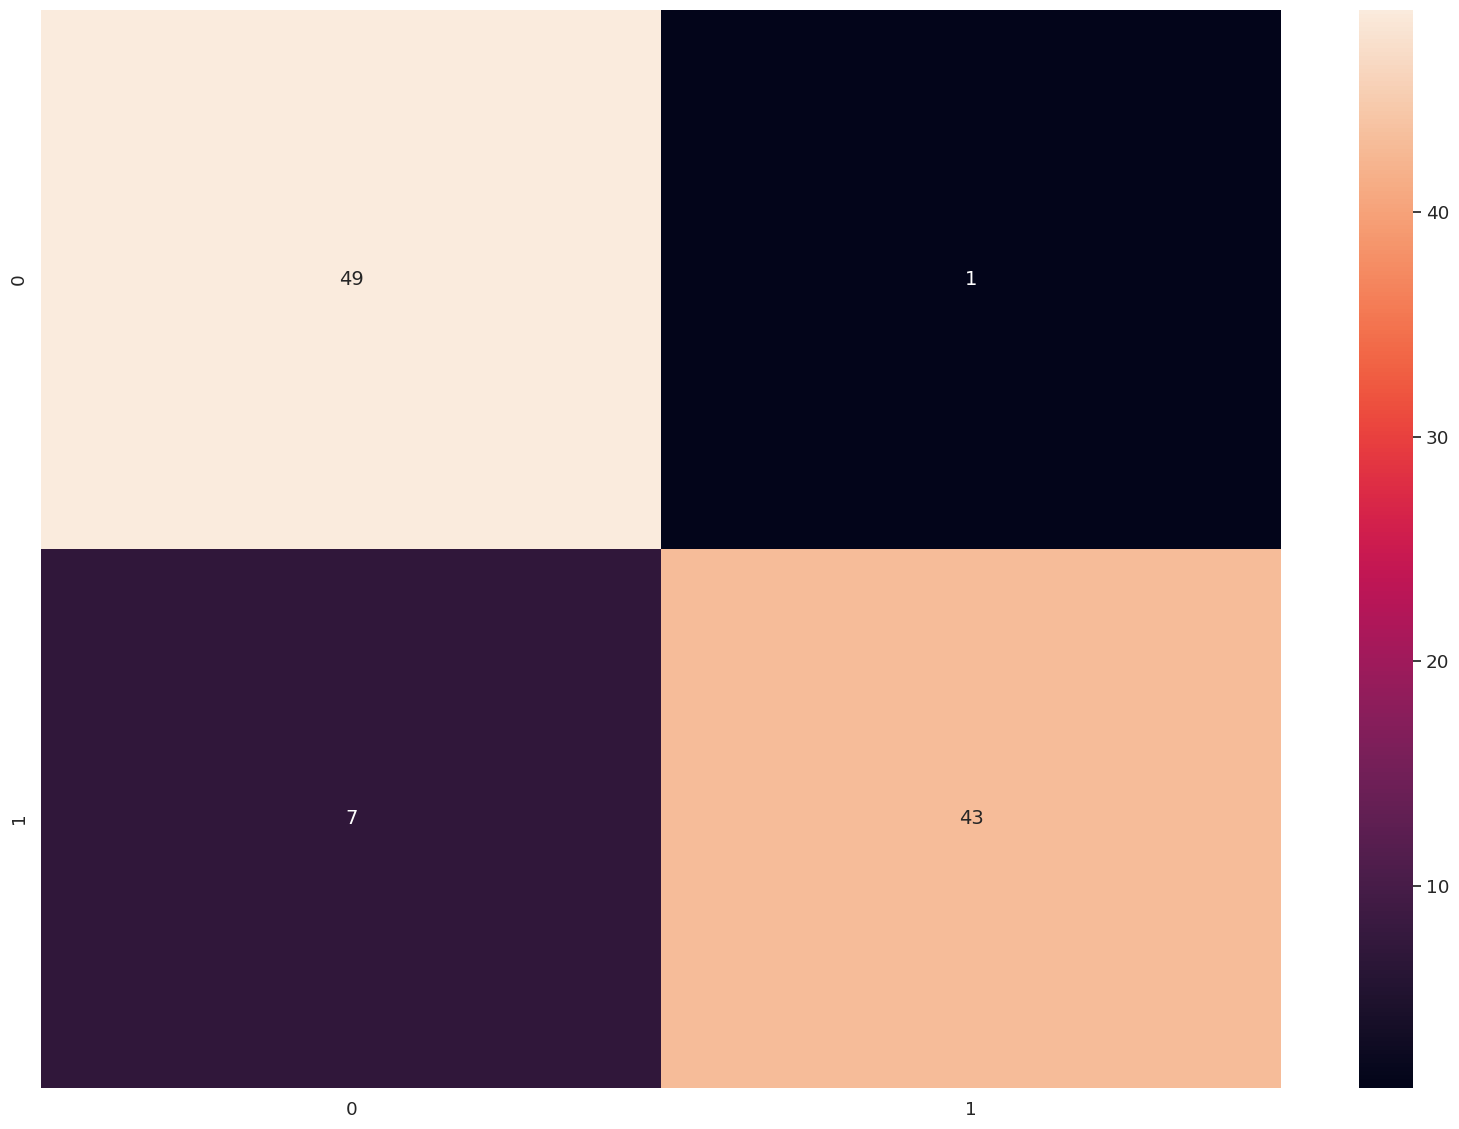

In [ ]:
# import seaborn as sn
# import matplotlib.pyplot as plt


df_cm = pd.DataFrame(cm, range(2), range(2))
plt.figure(figsize=(20,14))
sn.set(font_scale=1.2) # for label size
sn.heatmap(df_cm, annot=True, annot_kws={"size": 14}, fmt='g') # for num predict size

plt.show()

- ดึง Intent ทั้งหมดมาจาก output_tokenizer

In [ ]:
label_dict = output_tokenizer.word_index

- ดึงชื่อของ Intent เก็บใน Label

In [ ]:
label = [key for key, value in label_dict.items()]

- แสดง Precision, Recall, F1-score

In [ ]:
print(classification_report(y_true, predicted_classes, target_names=label, digits=4))

              precision    recall  f1-score   support

         pos     0.8750    0.9800    0.9245        50
         neg     0.9773    0.8600    0.9149        50

    accuracy                         0.9200       100
   macro avg     0.9261    0.9200    0.9197       100
weighted avg     0.9261    0.9200    0.9197       100



## 02 : CNN

- นิยาม Model

In [ ]:
# from tensorflow.keras.optimizers import Adam
adam = Adam(learning_rate = 0.0001)

- กำหนดจำนวน EPOCHS และ Batch Size และ DIMENSION ดังต่อไปนี้

In [ ]:
EPOCHS = 100
BS = 32
DIMENSION = 128

In [ ]:
# define the model
def define_model(length, vocab_size):

    # channel 1
    inputs1 = tf.keras.layers.Input(shape=(length,))
    embedding1 = tf.keras.layers.Embedding(vocab_size, DIMENSION, trainable = True)(inputs1)
    conv1 = tf.keras.layers.Conv1D(filters=32, kernel_size=4, activation='relu')(embedding1)
    drop1 = tf.keras.layers.Dropout(0.5)(conv1)
    pool1 = tf.keras.layers.MaxPooling1D(pool_size=2)(drop1)
    flat1 = tf.keras.layers.Flatten()(pool1)

    # channel 2
    inputs2 = tf.keras.layers.Input(shape=(length,))
    embedding2 = tf.keras.layers.Embedding(vocab_size, DIMENSION, trainable = True)(inputs2)
    conv2 = tf.keras.layers.Conv1D(filters=32, kernel_size=6, activation='relu')(embedding2)
    drop2 = tf.keras.layers.Dropout(0.5)(conv2)
    pool2 = tf.keras.layers.MaxPooling1D(pool_size=2)(drop2)
    flat2 = tf.keras.layers.Flatten()(pool2)

    # channel 3
    inputs3 = tf.keras.layers.Input(shape=(length,))
    embedding3 = tf.keras.layers.Embedding(vocab_size, DIMENSION, trainable = True)(inputs3)
    conv3 = tf.keras.layers.Conv1D(filters=32, kernel_size=8, activation='relu')(embedding3)
    drop3 = tf.keras.layers.Dropout(0.5)(conv3)
    pool3 = tf.keras.layers.MaxPooling1D(pool_size=2)(drop3)
    flat3 = tf.keras.layers.Flatten()(pool3)

    # merge
    merged = tf.keras.layers.concatenate([flat1, flat2, flat3])

    # interpretation
    dense1 = tf.keras.layers.Dense(10, activation='relu')(merged)
    outputs = tf.keras.layers.Dense(num_classes, activation='softmax')(dense1)
    model = Model(inputs=[inputs1, inputs2, inputs3], outputs=outputs)

    # compile
    model.compile(loss='categorical_crossentropy', optimizer=adam, metrics=['accuracy'])

    # summarize
    print(model.summary())

#     plot_model(model, show_shapes=True, to_file='multichannel.png')
    return model

In [ ]:
model = define_model(max_length, vocab_size)

Model: "model_6"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_19 (InputLayer)       [(None, 51)]                 0         []                            
                                                                                                  
 input_20 (InputLayer)       [(None, 51)]                 0         []                            
                                                                                                  
 input_21 (InputLayer)       [(None, 51)]                 0         []                            
                                                                                                  
 embedding_21 (Embedding)    (None, 51, 128)              216832    ['input_19[0][0]']            
                                                                                            

- กำหนดจุด Checkpoint

In [ ]:
filename = 'model_tmsa_sentiment_cnn.h5'
checkpoint = ModelCheckpoint(filename, monitor='val_loss', verbose=1, save_best_only=True, mode='min')

- ใช้ ReduceLROnPlateau เพื่อปรับ Learning Rate

In [ ]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_loss', patience = 3, verbose=1,factor=0.1, min_lr=0.000001)
callbacks_list = [checkpoint, learning_rate_reduction]

In [ ]:
hist = model.fit([train_X, train_X, train_X], train_Y,
                        epochs = EPOCHS,
                         batch_size = BS,
                         validation_data = ([val_X, val_X, val_X], val_Y),
                         callbacks = [callbacks_list],
                         shuffle=True
                      )

Epoch 1/100
13/13 [==============================] - ETA: 0s - loss: 0.6932 - accuracy: 0.5175
Epoch 1: val_loss improved from inf to 0.68942, saving model to model_tmsa_sentiment_cnn.h5
13/13 [==============================] - 7s 410ms/step - loss: 0.6932 - accuracy: 0.5175 - val_loss: 0.6894 - val_accuracy: 0.5500 - lr: 1.0000e-04
Epoch 2/100


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning:

You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.



13/13 [==============================] - ETA: 0s - loss: 0.6875 - accuracy: 0.5700
Epoch 2: val_loss improved from 0.68942 to 0.68803, saving model to model_tmsa_sentiment_cnn.h5
13/13 [==============================] - 5s 361ms/step - loss: 0.6875 - accuracy: 0.5700 - val_loss: 0.6880 - val_accuracy: 0.6000 - lr: 1.0000e-04
Epoch 3/100
13/13 [==============================] - ETA: 0s - loss: 0.6801 - accuracy: 0.6075
Epoch 3: val_loss improved from 0.68803 to 0.68725, saving model to model_tmsa_sentiment_cnn.h5
13/13 [==============================] - 4s 302ms/step - loss: 0.6801 - accuracy: 0.6075 - val_loss: 0.6872 - val_accuracy: 0.5200 - lr: 1.0000e-04
Epoch 4/100
13/13 [==============================] - ETA: 0s - loss: 0.6746 - accuracy: 0.6475
Epoch 4: val_loss improved from 0.68725 to 0.68547, saving model to model_tmsa_sentiment_cnn.h5
13/13 [==============================] - 3s 267ms/step - loss: 0.6746 - accuracy: 0.6475 - val_loss: 0.6855 - val_accuracy: 0.6200 - lr: 1.0000

- Save History

In [ ]:
with open('history_model_tmsa_sentiment_cnn', 'wb') as file:
    p.dump(hist.history, file)

- Load History

In [ ]:
with open('history_model_tmsa_sentiment_cnn', 'rb') as file:
    his = p.load(file)

-  Plot `Loss` และ `Validate Loss`

In [ ]:
h1 = go.Scatter(y=hist.history['loss'],
                    mode="lines", line=dict(
                    width=2,
                    color='blue'),
                    name="loss"
                   )
h2 = go.Scatter(y=hist.history['val_loss'],
                    mode="lines", line=dict(
                    width=2,
                    color='red'),
                    name="val_loss"
                   )

data = [h1,h2]
layout1 = go.Layout(title='Loss',
                   xaxis=dict(title='epochs'),
                   yaxis=dict(title=''))
fig1 = go.Figure(data = data, layout=layout1)
fig1.show()

- Plot `Accuracy` และ `Validate Accuracy`

In [ ]:
h1 = go.Scatter(y=hist.history['accuracy'],
                    mode="lines", line=dict(
                    width=2,
                    color='blue'),
                    name="acc"
                   )
h2 = go.Scatter(y=hist.history['val_accuracy'],
                    mode="lines", line=dict(
                    width=2,
                    color='red'),
                    name="val_acc"
                   )

data = [h1,h2]
layout1 = go.Layout(title='Accuracy',
                   xaxis=dict(title='epochs'),
                   yaxis=dict(title=''))
fig1 = go.Figure(data = data, layout=layout1)
fig1.show()

- Load และ Print ชนิดของ Layer, Output Shape และจำนวน Parameter ของ Model

In [ ]:
predict_model = load_model(filename)
predict_model.summary()

Model: "model_6"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_19 (InputLayer)       [(None, 51)]                 0         []                            
                                                                                                  
 input_20 (InputLayer)       [(None, 51)]                 0         []                            
                                                                                                  
 input_21 (InputLayer)       [(None, 51)]                 0         []                            
                                                                                                  
 embedding_21 (Embedding)    (None, 51, 128)              216832    ['input_19[0][0]']            
                                                                                            

- Evaluate Model

In [ ]:
score = predict_model.evaluate([val_X, val_X, val_X], val_Y, verbose=0)
print('Validate loss:', score[0])
print('Validate accuracy:', score[1])

Validate loss: 0.2520506978034973
Validate accuracy: 0.9100000262260437


- Predict ด้วย Validate Dataset

In [ ]:
predicted_classes = np.argmax(predict_model.predict([val_X, val_X, val_X]), axis=-1)
predicted_classes.shape

4/4 [==============================] - 0s 2ms/step


(100,)

- เปลี่ยน y_true จาก One Hot กลับเป็นเลขจำนวนเต็มฐานสิบ

In [ ]:
y_true = np.argmax(val_Y,axis = 1)
print(val_Y[0])
print(y_true[0])

[0. 1.]
1


- Save Confusion Matrix

In [ ]:
cm = confusion_matrix(y_true, predicted_classes)
np.savetxt("confusion_matrix_tmsa_sentiment_cnn.csv", cm, delimiter=",")

- Plot Confusion Matrix

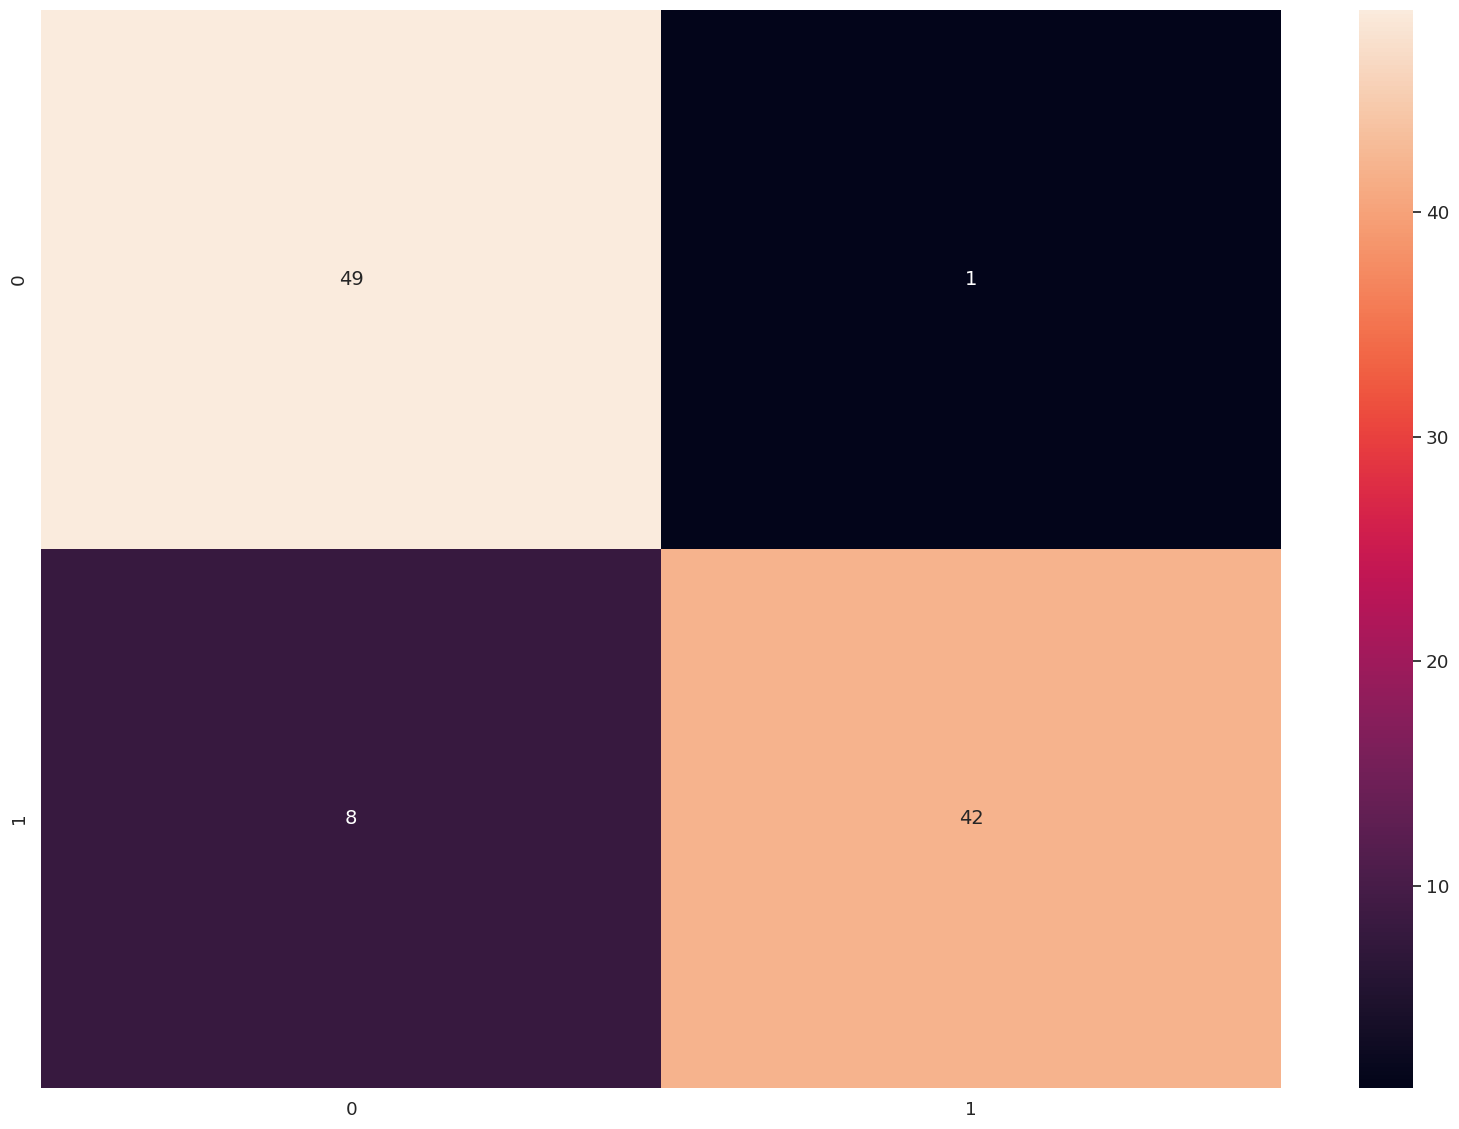

In [ ]:
#import seaborn as sn
#import matplotlib.pyplot as plt

df_cm = pd.DataFrame(cm, range(2), range(2))
plt.figure(figsize=(20,14))
sn.set(font_scale=1.2) # for label size
sn.heatmap(df_cm, annot=True, annot_kws={"size": 14}, fmt='g') # for num predict size

plt.show()

- ดึง Intent ทั้งหมดมาจาก output_tokenizer

In [ ]:
label_dict = output_tokenizer.word_index

- ดึงชื่อของ Intent เก็บใน Label

In [ ]:
label = [key for key, value in label_dict.items()]

- แสดง Precision, Recall, F1-score

In [ ]:
print(classification_report(y_true, predicted_classes, target_names=label, digits=4))

              precision    recall  f1-score   support

         pos     0.8596    0.9800    0.9159        50
         neg     0.9767    0.8400    0.9032        50

    accuracy                         0.9100       100
   macro avg     0.9182    0.9100    0.9096       100
weighted avg     0.9182    0.9100    0.9096       100



# การส่งงาน (Please delete before submission)

- Copy ไปรันใน Account ของ 65056071@kmitl.ac.th (และ Account นี้เป็นบัญชีสำรอง)
- ให้ส่งใน Folder ที่ได้รับสิทธิ์ โดยให้นักศึกษาสร้าง Folder ย่อยตามจำนวนข้อที่ส่ง
- สิ่งที่ต้องส่งแต่ละข้อ คือ Clip การอธิบาย และ File ประกอบทั้งหมด
- Deadline : วันอาทิตย์ที่ 10 กันยายน เวลา 23.59